In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import mmcv
import importlib
import torch
import torchvision.transforms as transforms
from mmcv import Config
from mmcls.datasets.pipelines import Compose
from mmcls.models.builder import build_classifier
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from matplotlib import cm
from PIL import Image
import heapq
from mmseg.apis import inference_segmentor, init_segmentor
from mmseg.core.evaluation import get_palette
from mmseg.datasets.builder import build_dataset, build_dataloader, DATASETS
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
import pandas
import json

import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    

from scripts import generate_statistics_single
from scripts import visualization_seg_masks
from scripts import generate_statistics
from scripts import generate_cams
from scripts import utils
from scripts.utils.pipeline import get_pipeline_torchvision
from scripts import generate_segs
from scripts import visualize_cam_results
from scripts.utils.BlurDataset import get_blurred_dataset
from scripts.utils import preprocessing, io
from scripts.utils.model import get_wrongly_classified
from scripts.utils.evaluation import compare_original_blurred
from scripts import evaluate_effectiveness

Importing BlurSegments step into Pipeline


In [2]:
configSeg = '../segmentation/ocrnet_hr48_512x512_carparts_noflip/ocrnet_hr48_512x512_carparts_noflip.py'
checkpointSeg = '../segmentation/ocrnet_hr48_512x512_carparts_noflip/latest.pth'
imgRootTrain = '../data/CompCars_sv_original_split/train'
imgRootVal = '../data/CompCars_sv_original_split/val'
configCAMResOG = '../CAMModels/resnet/compCars_Original/resnet50_b128x2_compcars-original-split.py'
checkpointCAMResOG = '../CAMModels/resnet/compCars_Original/latest.pth'
configCAMSwinSmallOG = '../CAMModels/swinSmall/compCars_Original/swin-small_b128x2_compcars-original-split.py'
checkpointCAMSwinSmallOG = '../CAMModels/swinSmall/compCars_Original/latest.pth'
annfileTrain = '../annfileTrain.txt'
annfileVal = '../annfileVal.txt'
annfileValGt = '../annfileValGt.txt'
imgNameTrain='Acura_Acura_ILX_2a6cce617fc27d.jpg'
imgNameVal = 'Acura_Acura_ILX_3c11ef9e42931b.jpg'
imgPathTrain=os.path.join(imgRootTrain, imgNameTrain)
imgPathVal=os.path.join(imgRootVal, imgNameVal)

imgRootValOriginal = '../data/CompCars_sv_original_split/val'
imgRootValColor = '../data/CompCars_sv_color_split/val'
imgRootValWeb = '../data/CompCars_web_original_split/val'

annfileValOriginal = '../data/CompCars_sv_original_split/meta/val.txt'
annfileValColor = '../data/CompCars_sv_color_split/meta/val.txt'
annfileValWeb = '../data/CompCars_web_original_split/meta/val.txt'

paletteName='Comp_Original_Ocrnet_Carparts_Noflip'

segDataPath = 'G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Original/valAllSegs.npz'
segDataPathNoScale = 'G:/XAI-Vehicle-Classification/preGenData/Segmentations/CompCars_Original/valAllSegsNoScale.npz'

camDataGradCAM = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMs.npz'
camDataEigenCAM = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMsEigen.npz'
camDataEigenGrad = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMsEigenGrad.npz'
camDataGradCAMGPU = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMsGPU.npz'
camDataGradCAMPlusPlus = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMsGrad++.npz'
camDataLayerCAM = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMsLayer.npz'
camDataXCAM = 'G:/XAI-Vehicle-Classification/preGenData/CompCars_original/ResNet/valAllCAMsXGrad.npz'

In [65]:
imgRootBlurredBackground = '../data/CompCars_sv_original_split/blurred/blurredBackground'
evaluate_effectiveness.evaluate_blurred_background(imgRoot=imgRootValOriginal, classifierConfig=configCAMResOG, 
                                                   classifierCheckpoint=checkpointCAMResOG, annfile=annfileValOriginal,
                                                   segData=segDataPathNoScale, segConfig=configSeg, saveImgs=False,
                                                   segCheckpoint=checkpointSeg,  saveDir='compareResults/newLoad',
                                                   eval_data_original='./eval_results_original.json',
                                                   imgRootBlurred=imgRootBlurredBackground)

Evaluating original model vs blurred background.
Evaluating original model vs blurred where segments background are blurred.
Created filtered annotation file at compareResults/newLoad\annfile_filtered.txt
Using standard dataset on blurred data at directory ../data/CompCars_sv_original_split/blurred/blurredBackground
Model already on GPU
Using given evaluation data of original model.
Loading data from Json ./eval_results_original.json
Computing Evaluation Metrics for Blurred Dataset
[>>>>>>>>>>>>>>>>>>>>>>>>] 13333/13333, 267.7 task/s, elapsed: 50s, ETA:     0s
Saving json data to compareResults/newLoad\eval_results_blurred.json
Add total Change and improvement of original over blurred
Saving evaluation results to compareResults/newLoad\evalBlurred.xlsx
Removing temporary filtered annotation file compareResults/newLoad\annfile_filtered.txt


In [6]:
imgRootBlurredBackground = '../data/CompCars_sv_original_split/blurred/blurredBackground'
q = generate_cams.main([imgRootBlurredBackground, configCAMResOG, checkpointCAMResOG, '-s', 'compare/load', 
                    '--classes', 'Acura_Acura_ILX_261c0c61071ba2'])

Method for CAM generation: GradCAM, eigen-smooth:False, aug-smooth:False, vit-like:False
Generate Results for specified files
Automatically choose the last norm layer as target_layer.
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 3.8 task/s, elapsed: 0s, ETA:     0s
Save Split file for Cams
Creating annotation file at compare\load.txt
Save generated CAMs to compare\load.npz


In [7]:
w = generate_cams.main([imgRootValOriginal, configCAMResOG, checkpointCAMResOG, '-s', 'compare/gen', 
                    '--blurredSegments', 'background', '--segConfig', configSeg, '--segCheckpoint', checkpointSeg,
                    '--segData', segDataPathNoScale, '--saveBlurred', '--classes', 'Acura_Acura_ILX_261c0c61071ba2'])

Generating CAMs using blurred images.
Modifying pipeline cfg so that specified segments background will be blurred out.
Method for CAM generation: GradCAM, eigen-smooth:False, aug-smooth:False, vit-like:False
Generate Results for specified files
Automatically choose the last norm layer as target_layer.
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1/1, 2.0 task/s, elapsed: 1s, ETA:     0s
Save Split file for Cams
Creating annotation file at compare/gen\resultsCAM.txt
Save generated CAMs to compare/gen\resultsCAM.npz


In [8]:
with np.load('compare/load.npz') as l, np.load('compare/gen/resultsCAM.npz') as g, np.load(camDataGradCAM) as c:
    j = l['Acura_Acura_ILX_261c0c61071ba2.jpg']
    k = g['Acura_Acura_ILX_261c0c61071ba2.jpg']
    s = c['Acura_Acura_ILX_261c0c61071ba2.jpg']

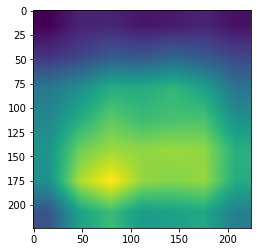

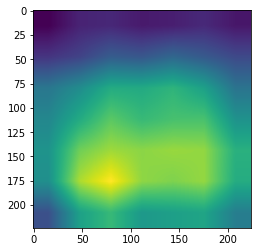

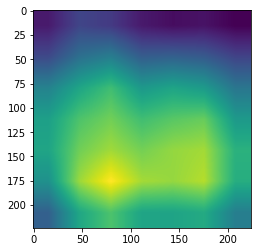

In [9]:
plt.imshow(j)
plt.show()
plt.imshow(k)
plt.show()
plt.imshow(s)

Using given results from file C:/Users/Linus/Desktop/results/CompCars_Original/ResNet/wronglyClassifications\Data_Full_EigenCAM_ResNet_CompCars_Original_ocrnet_hr48_carparts_noflip_wrongClassified_21_08_2022.xlsx


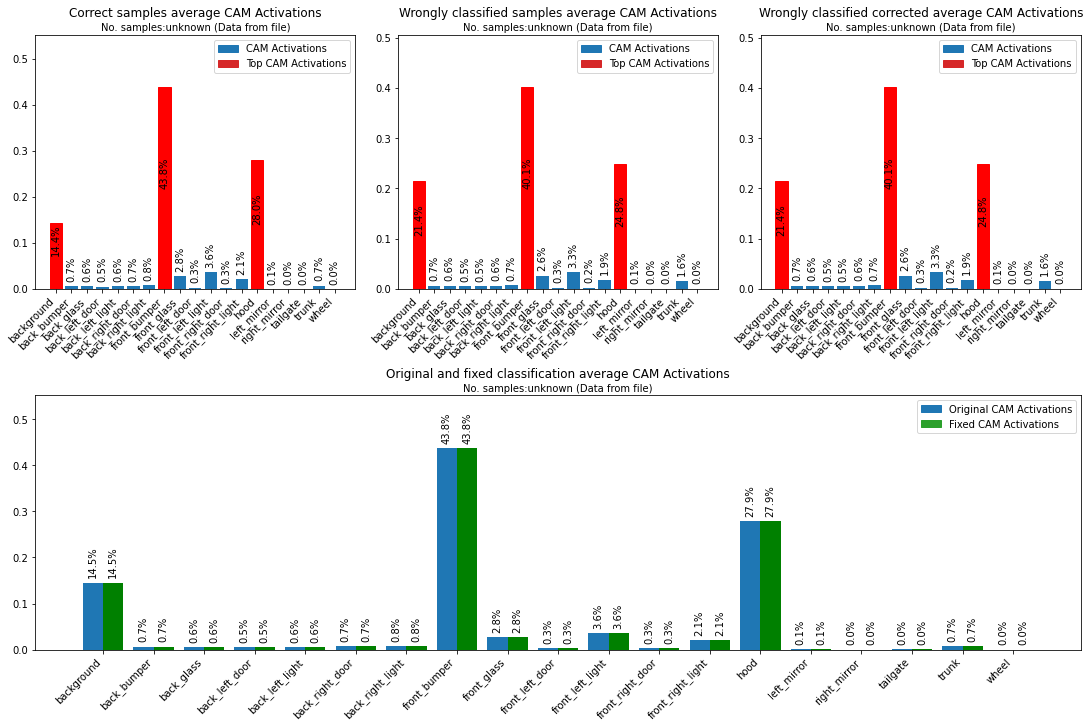

C:\Users\Linus\Desktop\XAI-Vehicle-Classification\scripts\generate_statistics.py:527: UserWarning: No filename is set. Using default: resultsMissclassified
  'PercActivationsIncorrect' : summarizedPercCAMActivationsIncorrect,


Output path is not a directory. Using base directory: ../results/CompCars_Original/ResNet\wronglyClassifications.
Saving images to: ../results/CompCars_Original/ResNet\wronglyClassifications\resultsMissclassified.jpg
Generate excel file for results.
Using specified dictionary keys as column names
Saving excel to ../results/CompCars_Original/ResNet\wronglyClassifications\wronglyClassified_resultsMissclassified.xlsx.


In [20]:
resultsDir = 'C:/Users/Linus/Desktop/results/CompCars_Original/ResNet/wronglyClassifications'
resultsFileName = 'Data_Full_EigenCAM_ResNet_CompCars_Original_ocrnet_hr48_carparts_noflip_wrongClassified_21_08_2022.xlsx'
resultsPath = os.path.join(resultsDir, resultsFileName)
df = generate_statistics.generate_statistics_missclassified(results_file=resultsPath, saveDir='../results/CompCars_Original/ResNet')